In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tomatodata/Imputed_Price_Arrivals_Lat_Long_Weather_Tomato.csv


In [2]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from pathlib import Path
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


In [5]:
class FastSpatiotemporalPreprocessor:
    """Optimized preprocessor with progress tracking"""
    
    def __init__(self, data_path: str, k_neighbors: int = 10, 
                 sequence_length: int = 60, forecast_horizon: int = 10,
                 sample_mandis: int = None):
        self.data_path = data_path
        self.k_neighbors = k_neighbors
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.sample_mandis = sample_mandis
        
        self.df = None
        self.mandi_to_idx = {}
        self.idx_to_mandi = {}
        self.crop_to_idx = {}
        self.idx_to_crop = {}
        self.price_scaler = StandardScaler()
        self.feature_scaler = StandardScaler()
        self.edge_index = None
        self.edge_weights = None
        
    def load_and_clean_data(self):
        print("Loading wheat dataset...")
        df = pd.read_csv(self.data_path)
        print(f"Loaded {len(df):,} rows")
        
        df['Market_ID'] = df['State'] + " | " + df['District'] + " | " + df['Market']
        df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')
        
        if self.sample_mandis:
            print(f"Sampling {self.sample_mandis} mandis for quick testing...")
            sampled_mandis = df['Market_ID'].unique()[:self.sample_mandis]
            df = df[df['Market_ID'].isin(sampled_mandis)]
            print(f"After sampling: {len(df):,} rows")
        
        df = df.sort_values(['Market_ID', 'Date']).reset_index(drop=True)
        
        if 'Crop' not in df.columns:
            df['Crop'] = 'Wheat'
        
        if 't_mean' not in df.columns:
            print("Calculating temperature means...")
            temp_cols = [f't{i:02d}' for i in range(24)]
            df['t_mean'] = df[temp_cols].mean(axis=1)
        
        if 'r_mean' not in df.columns:
            print("Calculating rainfall means...")
            rain_cols = [f'r{i:02d}' for i in range(24)]
            df['r_mean'] = df[rain_cols].mean(axis=1)
        
        keep_cols = ['Market_ID', 'Date', 'Crop', 'Imp_Price', 
                    'Latitude_rounded', 'Longitude_rounded', 't_mean', 'r_mean']
        df = df[keep_cols].copy()
        
        df = df.dropna(subset=['Imp_Price', 'Latitude_rounded', 'Longitude_rounded'])
        df['t_mean'] = df.groupby('Market_ID')['t_mean'].fillna(method='ffill')
        df['r_mean'] = df.groupby('Market_ID')['r_mean'].fillna(method='ffill')
        
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['DayOfYear'] = df['Date'].dt.dayofyear
        
        print(f"After cleaning: {len(df):,} rows")
        print(f"Unique markets: {df['Market_ID'].nunique()}")
        
        self.df = df
        return df
    
    def create_mappings(self):
        unique_mandis = sorted(self.df['Market_ID'].unique())
        self.mandi_to_idx = {m: i for i, m in enumerate(unique_mandis)}
        self.idx_to_mandi = {i: m for m, i in self.mandi_to_idx.items()}
        
        unique_crops = sorted(self.df['Crop'].unique())
        self.crop_to_idx = {c: i for i, c in enumerate(unique_crops)}
        self.idx_to_crop = {i: c for c, i in self.crop_to_idx.items()}
        
        self.df['mandi_idx'] = self.df['Market_ID'].map(self.mandi_to_idx)
        self.df['crop_idx'] = self.df['Crop'].map(self.crop_to_idx)
        
        print(f"Mapped {len(self.mandi_to_idx)} mandis, {len(self.crop_to_idx)} crops")
    
    def build_spatial_graph(self):
        print(f"Building spatial graph (k={self.k_neighbors})...")
        
        mandi_coords = self.df.groupby('Market_ID').agg({
            'Latitude_rounded': 'first',
            'Longitude_rounded': 'first',
            'mandi_idx': 'first'
        }).sort_values('mandi_idx')
        
        coords = mandi_coords[['Latitude_rounded', 'Longitude_rounded']].values
        
        nbrs = NearestNeighbors(n_neighbors=self.k_neighbors + 1, metric='haversine')
        nbrs.fit(np.radians(coords))
        distances, indices = nbrs.kneighbors(np.radians(coords))
        
        edge_list = []
        edge_weights = []
        
        for i in range(len(coords)):
            for j, dist in zip(indices[i][1:], distances[i][1:]):
                edge_list.append([i, j])
                edge_weights.append(1.0 / (dist + 1e-6))
        
        self.edge_index = np.array(edge_list).T
        self.edge_weights = np.array(edge_weights)
        
        for i in range(len(coords)):
            mask = self.edge_index[0] == i
            if mask.sum() > 0:
                self.edge_weights[mask] /= self.edge_weights[mask].sum()
        
        print(f"Graph: {len(coords)} nodes, {len(edge_list)} edges")
        return self.edge_index, self.edge_weights
    
    def create_temporal_sequences_fast(self):
        print(f"Creating sequences (input={self.sequence_length}, output={self.forecast_horizon})...")
        
        sequences = {'X': [], 'y': [], 'mandi_idx': [], 'crop_idx': [], 'dates': []}
        
        feature_cols = ['Imp_Price', 'Month', 'DayOfWeek', 'DayOfYear', 't_mean', 'r_mean']
        min_length = self.sequence_length + self.forecast_horizon
        
        grouped = self.df.groupby('Market_ID')
        
        for mandi_id, group in tqdm(grouped, desc="Processing mandis"):
            group = group.sort_values('Date').reset_index(drop=True)
            
            if len(group) < min_length:
                continue
            
            n_sequences = len(group) - min_length + 1
            features = group[feature_cols].values
            mandi_idx = group['mandi_idx'].iloc[0]
            crop_idx = group['crop_idx'].iloc[0]
            dates = group['Date'].values
            
            for i in range(n_sequences):
                X = features[i:i + self.sequence_length]
                y = features[i + self.sequence_length:i + self.sequence_length + self.forecast_horizon, 0]
                
                sequences['X'].append(X)
                sequences['y'].append(y)
                sequences['mandi_idx'].append(mandi_idx)
                sequences['crop_idx'].append(crop_idx)
                sequences['dates'].append(dates[i + self.sequence_length - 1])
        
        sequences['X'] = np.array(sequences['X'], dtype=np.float32)
        sequences['y'] = np.array(sequences['y'], dtype=np.float32)
        sequences['mandi_idx'] = np.array(sequences['mandi_idx'], dtype=np.int64)
        sequences['crop_idx'] = np.array(sequences['crop_idx'], dtype=np.int64)
        
        print(f"Created {len(sequences['X']):,} sequences")
        return sequences
    
    def normalize_features(self, sequences):
        print("Normalizing...")
        
        num_seq, seq_len, num_features = sequences['X'].shape
        X_reshaped = sequences['X'].reshape(-1, num_features)
        X_normalized = self.feature_scaler.fit_transform(X_reshaped)
        sequences['X'] = X_normalized.reshape(num_seq, seq_len, num_features)
        
        y_reshaped = sequences['y'].reshape(-1, 1)
        y_normalized = self.price_scaler.fit_transform(y_reshaped)
        sequences['y'] = y_normalized.reshape(num_seq, self.forecast_horizon)
        
        return sequences
    
    def temporal_train_val_test_split(self, sequences):
        print("Splitting data...")
        
        dates = np.array(sequences['dates'])
        sort_idx = np.argsort(dates)
        
        n = len(sort_idx)
        train_end = int(n * 0.8)
        val_end = int(n * 0.9)
        
        train_idx = sort_idx[:train_end]
        val_idx = sort_idx[train_end:val_end]
        test_idx = sort_idx[val_end:]
        
        train_data = {k: v[train_idx] if k != 'dates' else None 
                     for k, v in sequences.items() if k != 'dates'}
        val_data = {k: v[val_idx] if k != 'dates' else None 
                   for k, v in sequences.items() if k != 'dates'}
        test_data = {k: v[test_idx] if k != 'dates' else None 
                    for k, v in sequences.items() if k != 'dates'}
        
        print(f"Train: {len(train_data['X']):,} | Val: {len(val_data['X']):,} | Test: {len(test_data['X']):,}")
        
        return train_data, val_data, test_data
    
    def run_preprocessing(self):
        print("="*60)
        print("GAT-LSTM Data Preprocessing")
        print("="*60)
        
        self.load_and_clean_data()
        self.create_mappings()
        self.build_spatial_graph()
        sequences = self.create_temporal_sequences_fast()
        sequences = self.normalize_features(sequences)
        train_data, val_data, test_data = self.temporal_train_val_test_split(sequences)
        
        metadata = {
            'mandi_to_idx': self.mandi_to_idx,
            'idx_to_mandi': self.idx_to_mandi,
            'crop_to_idx': self.crop_to_idx,
            'idx_to_crop': self.idx_to_crop,
            'price_scaler': self.price_scaler,
            'feature_scaler': self.feature_scaler,
            'config': {
                'k_neighbors': self.k_neighbors,
                'sequence_length': self.sequence_length,
                'forecast_horizon': self.forecast_horizon,
                'num_mandis': len(self.mandi_to_idx),
                'num_crops': len(self.crop_to_idx),
                'num_features': 6
            }
        }
        
        graph_data = {'edge_index': self.edge_index, 'edge_weights': self.edge_weights}
        
        print(" Preprocessing complete!")
        return train_data, val_data, test_data, graph_data, metadata

In [6]:
class GATLayer(nn.Module):
    """Graph Attention Layer for spatial feature aggregation"""
    
    def __init__(self, in_features, out_features, num_heads=4, dropout=0.2, concat=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_heads = num_heads
        self.concat = concat
        
        # Linear transformations for each head
        self.W = nn.Parameter(torch.zeros(num_heads, in_features, out_features))
        self.a = nn.Parameter(torch.zeros(num_heads, 2 * out_features, 1))
        
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(0.2)
        
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.a)
    
    def forward(self, x, edge_index, edge_weights=None):
        batch_size, num_nodes, _ = x.shape
        
        # Linear transformation for all heads
        h = torch.einsum('bni,hio->bnho', x, self.W)
        
        # Compute attention coefficients
        src, dst = edge_index[0], edge_index[1]
        
        # Concatenate source and destination features
        h_src = h[:, src, :, :]
        h_dst = h[:, dst, :, :]
        h_cat = torch.cat([h_src, h_dst], dim=-1)
        
        # Compute attention scores
        e = torch.einsum('beho,hoi->behi', h_cat, self.a).squeeze(-1)
        e = self.leakyrelu(e)
        
        # Apply edge weights if provided
        if edge_weights is not None:
            e = e * edge_weights.unsqueeze(0).unsqueeze(-1)
        
        # Softmax over neighbors for each node
        attention = torch.zeros(batch_size, num_nodes, num_nodes, self.num_heads, device=x.device)
        attention[:, dst, src, :] = e
        
        # Normalize attention scores
        attention = F.softmax(attention, dim=2)
        attention = self.dropout(attention)
        
        # Aggregate features
        h_prime = torch.einsum('bnmh,bmho->bnho', attention, h)
        
        # Concatenate or average multi-head outputs
        if self.concat:
            return h_prime.reshape(batch_size, num_nodes, -1)
        else:
            return h_prime.mean(dim=2)


class GATEncoder(nn.Module):
    """Stack of GAT layers for spatial encoding"""
    
    def __init__(self, in_features, hidden_dim, num_heads=4, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        # First layer
        self.layers.append(GATLayer(in_features, hidden_dim, num_heads, dropout, concat=True))
        
        # Middle layers
        for _ in range(num_layers - 2):
            self.layers.append(GATLayer(hidden_dim * num_heads, hidden_dim, num_heads, dropout, concat=True))
        
        # Last layer (average instead of concat)
        if num_layers > 1:
            self.layers.append(GATLayer(hidden_dim * num_heads, hidden_dim, num_heads, dropout, concat=False))
    
    def forward(self, x, edge_index, edge_weights=None):
        for layer in self.layers:
            x = F.elu(layer(x, edge_index, edge_weights))
        return x


class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, 
                           dropout=dropout if num_layers > 1 else 0)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
    
    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, (hidden, cell)


class LSTMDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, hidden, forecast_horizon):
        predictions = []
        decoder_input = x
        
        for t in range(forecast_horizon):
            output, hidden = self.lstm(decoder_input, hidden)
            pred = self.fc(output)
            predictions.append(pred)
            decoder_input = output
        
        return torch.cat(predictions, dim=1)


class GATLSTMForecaster(nn.Module):
    """Full GAT-LSTM model with TRUE spatial and temporal components"""
    
    def __init__(self, num_mandis, num_crops, num_features=6,
                 mandi_embed_dim=32, crop_embed_dim=16,
                 gat_hidden_dim=64, gat_num_heads=4, gat_num_layers=2,
                 lstm_hidden_dim=128, lstm_num_layers=2,
                 forecast_horizon=10, dropout=0.2):
        super().__init__()
        
        self.num_mandis = num_mandis
        self.num_features = num_features
        self.gat_hidden_dim = gat_hidden_dim
        self.forecast_horizon = forecast_horizon
        
        # Embeddings
        self.mandi_embedding = nn.Embedding(num_mandis, mandi_embed_dim)
        self.crop_embedding = nn.Embedding(num_crops, crop_embed_dim)
        
        # GAT for spatial encoding
        self.gat = GATEncoder(num_features, gat_hidden_dim, gat_num_heads, gat_num_layers, dropout)
        
        # LSTM encoder for temporal encoding
        lstm_input_dim = gat_hidden_dim + mandi_embed_dim + crop_embed_dim
        self.lstm_encoder = LSTMEncoder(lstm_input_dim, lstm_hidden_dim, lstm_num_layers, dropout)
        
        # LSTM decoder for multi-step prediction
        self.lstm_decoder = LSTMDecoder(lstm_hidden_dim, lstm_hidden_dim, lstm_num_layers, dropout)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index, mandi_idx, crop_idx, edge_weights=None, 
                all_mandi_features=None):
        """
        Full spatiotemporal forward pass with REAL graph processing
        
        Args:
            x: Target mandi features (batch, seq_len, num_features)
            edge_index: Spatial graph edges (2, num_edges)
            mandi_idx: Target mandi indices (batch,)
            crop_idx: Crop indices (batch,)
            edge_weights: Edge weights (num_edges,)
            all_mandi_features: Features for ALL mandis (batch, seq_len, num_mandis, num_features)
                               If None, falls back to simplified mode
        """
        batch_size, seq_len, num_features = x.shape
        
        # Get embeddings
        mandi_emb = self.mandi_embedding(mandi_idx)  # (batch, mandi_embed_dim)
        crop_emb = self.crop_embedding(crop_idx)      # (batch, crop_embed_dim)
        
        # FULL GRAPH PROCESSING: Process all mandis through GAT at each timestep
        if all_mandi_features is not None:
            # all_mandi_features: (batch, seq_len, num_mandis, num_features)
            spatial_sequence = []
            
            for t in range(seq_len):
                # Get features for all mandis at timestep t
                features_t = all_mandi_features[:, t, :, :]  # (batch, num_mandis, num_features)
                
                # Apply GAT to aggregate from neighbors
                spatial_features_t = self.gat(features_t, edge_index, edge_weights)  # (batch, num_mandis, gat_hidden_dim)
                
                # Extract target mandi's spatially-aggregated features
                target_features_t = spatial_features_t[torch.arange(batch_size), mandi_idx]  # (batch, gat_hidden_dim)
                
                spatial_sequence.append(target_features_t)
            
            # Stack to create sequence
            spatial_features = torch.stack(spatial_sequence, dim=1)  # (batch, seq_len, gat_hidden_dim)
        
        else:
            # FALLBACK: Simplified mode (no graph processing)
            # Use a linear projection to match dimensions
            if not hasattr(self, 'feature_proj'):
                self.feature_proj = nn.Linear(num_features, self.gat_hidden_dim).to(x.device)
            spatial_features = self.feature_proj(x)  # (batch, seq_len, gat_hidden_dim)
        
        # Concatenate embeddings to each timestep
        emb = torch.cat([mandi_emb, crop_emb], dim=-1)  # (batch, embed_dim)
        emb = emb.unsqueeze(1).expand(-1, seq_len, -1)  # (batch, seq_len, embed_dim)
        
        combined = torch.cat([spatial_features, emb], dim=-1)  # (batch, seq_len, total_dim)
        combined = self.dropout(combined)
        
        # Encode temporal sequence
        encoder_outputs, (hidden, cell) = self.lstm_encoder(combined)
        
        # Decode multi-step predictions
        decoder_input = encoder_outputs[:, -1:, :]
        predictions = self.lstm_decoder(decoder_input, (hidden, cell), self.forecast_horizon)
        
        return predictions


In [7]:

class SpatiotemporalDataset(Dataset):
    def __init__(self, data, edge_index, edge_weights):
        self.X = torch.FloatTensor(data['X'])
        self.y = torch.FloatTensor(data['y'])
        self.mandi_idx = torch.LongTensor(data['mandi_idx'])
        self.crop_idx = torch.LongTensor(data['crop_idx'])
        self.edge_index = torch.LongTensor(edge_index)
        self.edge_weights = torch.FloatTensor(edge_weights)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'X': self.X[idx], 'y': self.y[idx],
            'mandi_idx': self.mandi_idx[idx], 'crop_idx': self.crop_idx[idx],
            'edge_index': self.edge_index, 'edge_weights': self.edge_weights
        }

def train_model(model, train_loader, val_loader, num_epochs=20, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            X = batch['X'].to(device)
            y = batch['y'].to(device)
            mandi_idx = batch['mandi_idx'].to(device)
            crop_idx = batch['crop_idx'].to(device)
            edge_index = batch['edge_index'][0].to(device)
            edge_weights = batch['edge_weights'][0].to(device)
            
            optimizer.zero_grad()
            predictions = model(X, edge_index, mandi_idx, crop_idx, edge_weights)
            loss = criterion(predictions.squeeze(-1), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
                X = batch['X'].to(device)
                y = batch['y'].to(device)
                mandi_idx = batch['mandi_idx'].to(device)
                crop_idx = batch['crop_idx'].to(device)
                edge_index = batch['edge_index'][0].to(device)
                edge_weights = batch['edge_weights'][0].to(device)
                
                predictions = model(X, edge_index, mandi_idx, crop_idx, edge_weights)
                loss = criterion(predictions.squeeze(-1), y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        
        print(f"\nEpoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✓ Saved best model (val_loss: {val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print("Early stopping!")
                break
    
    return model


In [8]:
DATA_PATH = '/kaggle/input/tomatodata/Imputed_Price_Arrivals_Lat_Long_Weather_Tomato.csv'

preprocessor = FastSpatiotemporalPreprocessor(
    data_path=DATA_PATH,
    k_neighbors=10,
    sequence_length=60,
    forecast_horizon=10,
    sample_mandis=None  # Set to 50 for quick test
)

train_data, val_data, test_data, graph_data, metadata = preprocessor.run_preprocessing()


GAT-LSTM Data Preprocessing
Loading wheat dataset...
Loaded 936,194 rows
Calculating temperature means...
Calculating rainfall means...
After cleaning: 936,194 rows
Unique markets: 233
Mapped 233 mandis, 1 crops
Building spatial graph (k=10)...
Graph: 233 nodes, 2330 edges
Creating sequences (input=60, output=10)...


Processing mandis: 100%|██████████| 233/233 [00:01<00:00, 174.49it/s]


Created 920,117 sequences
Normalizing...
Splitting data...
Train: 736,093 | Val: 92,012 | Test: 92,012
 Preprocessing complete!


In [9]:
train_dataset = SpatiotemporalDataset(train_data, graph_data['edge_index'], graph_data['edge_weights'])
val_dataset = SpatiotemporalDataset(val_data, graph_data['edge_index'], graph_data['edge_weights'])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)  # Larger batch for GPU
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

model = GATLSTMForecaster(
    num_mandis=metadata['config']['num_mandis'],
    num_crops=metadata['config']['num_crops'],
    num_features=metadata['config']['num_features'],
    forecast_horizon=metadata['config']['forecast_horizon']
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
model = train_model(model, train_loader, val_loader, num_epochs=20, device=device)

print("\n Training complete! Model saved as 'best_model.pth'")


Model parameters: 595,889


Epoch 1/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 114.84it/s]



Epoch 1: Train Loss = 0.130367, Val Loss = 0.350007
✓ Saved best model (val_loss: 0.350007)


Epoch 2/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 114.44it/s]



Epoch 2: Train Loss = 0.112466, Val Loss = 0.426602


Epoch 3/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 113.62it/s]



Epoch 3: Train Loss = 0.104062, Val Loss = 0.444825


Epoch 4/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 114.12it/s]



Epoch 4: Train Loss = 0.097862, Val Loss = 0.489079


Epoch 5/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 113.27it/s]



Epoch 5: Train Loss = 0.093379, Val Loss = 0.443799


Epoch 6/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 113.58it/s]



Epoch 6: Train Loss = 0.090258, Val Loss = 0.475008


Epoch 7/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 112.98it/s]



Epoch 7: Train Loss = 0.087953, Val Loss = 0.530096


Epoch 8/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 113.80it/s]



Epoch 8: Train Loss = 0.079462, Val Loss = 0.581138


Epoch 9/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 113.37it/s]



Epoch 9: Train Loss = 0.077013, Val Loss = 0.601825


Epoch 10/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 115.06it/s]



Epoch 10: Train Loss = 0.075440, Val Loss = 0.627769


Epoch 11/20 - Val: 100%|██████████| 1438/1438 [00:12<00:00, 113.70it/s]


Epoch 11: Train Loss = 0.074075, Val Loss = 0.608231
Early stopping!

 Training complete! Model saved as 'best_model.pth'


In [10]:
import pickle

print("\nSaving metadata...")
with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✓ Saved metadata.pkl")
print("\n📥 Download these files from Kaggle Output:")
print("  - best_model.pth (model weights)")
print("  - metadata.pkl (scalers & mappings)")
print("\nBoth files are needed for inference!")



Saving metadata...
✓ Saved metadata.pkl

📥 Download these files from Kaggle Output:
  - best_model.pth (model weights)
  - metadata.pkl (scalers & mappings)

Both files are needed for inference!


Evaluating on test set...


Testing: 100%|██████████| 1438/1438 [00:12<00:00, 113.06it/s]



EVALUATION METRICS

📊 Overall Performance:
  MSE: 102152.7891
  RMSE: 319.6135
  MAE: 198.2954
  R2: 0.8305
  MAPE: 16.7558

📈 Per-Day Performance:
Day    RMSE         MAE         
-----------------------------------
1      ₹196.48      ₹115.26     
2      ₹248.49      ₹149.28     
3      ₹277.59      ₹170.19     
4      ₹300.78      ₹187.30     
5      ₹320.15      ₹201.68     
6      ₹336.51      ₹213.98     
7      ₹350.27      ₹224.26     
8      ₹362.38      ₹233.27     
9      ₹372.44      ₹240.64     
10     ₹381.05      ₹247.09     

📊 Generating visualizations...


✓ Saved predictions plot: predictions.png


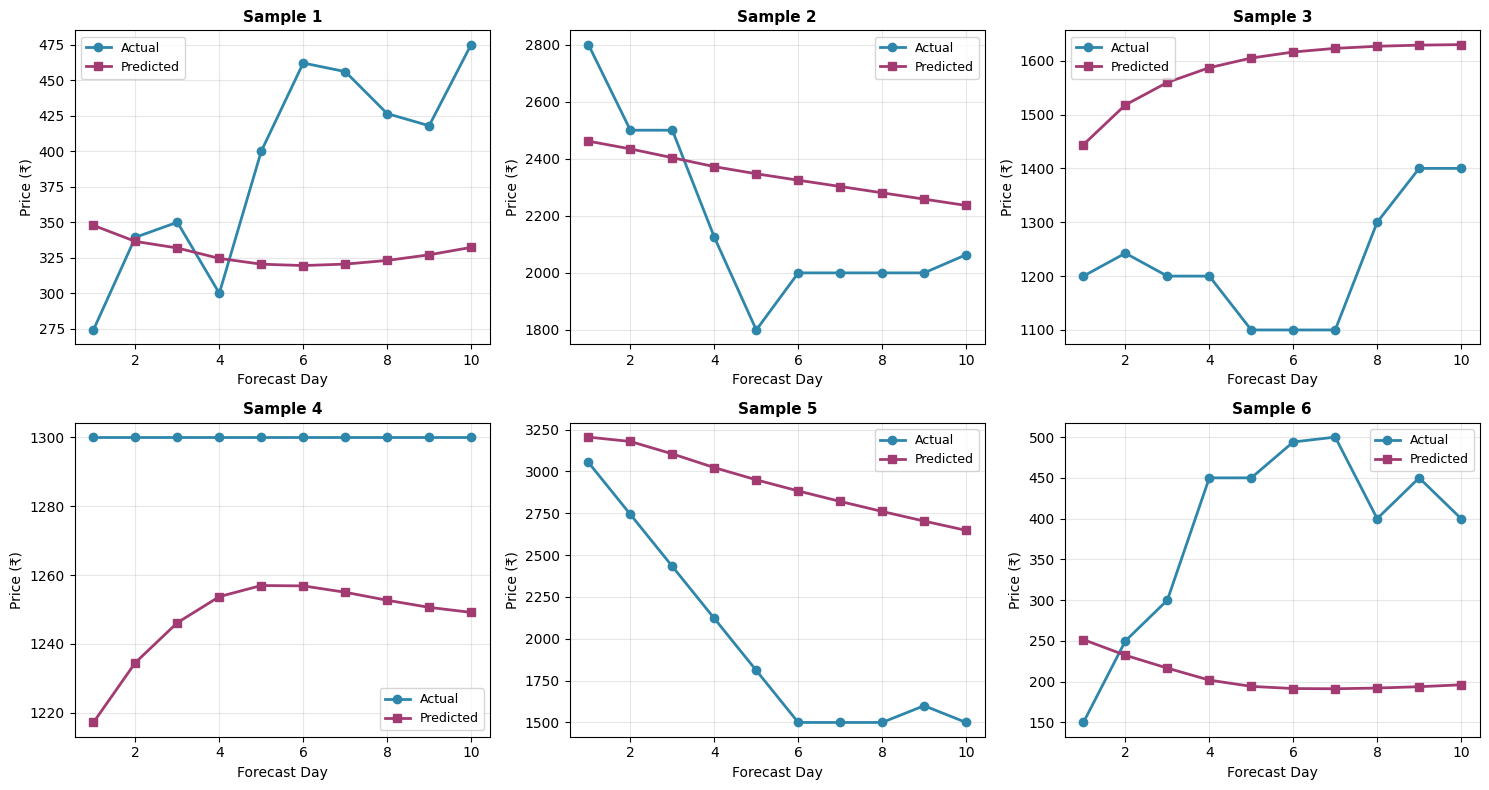

✓ Saved error distribution: error_distribution.png


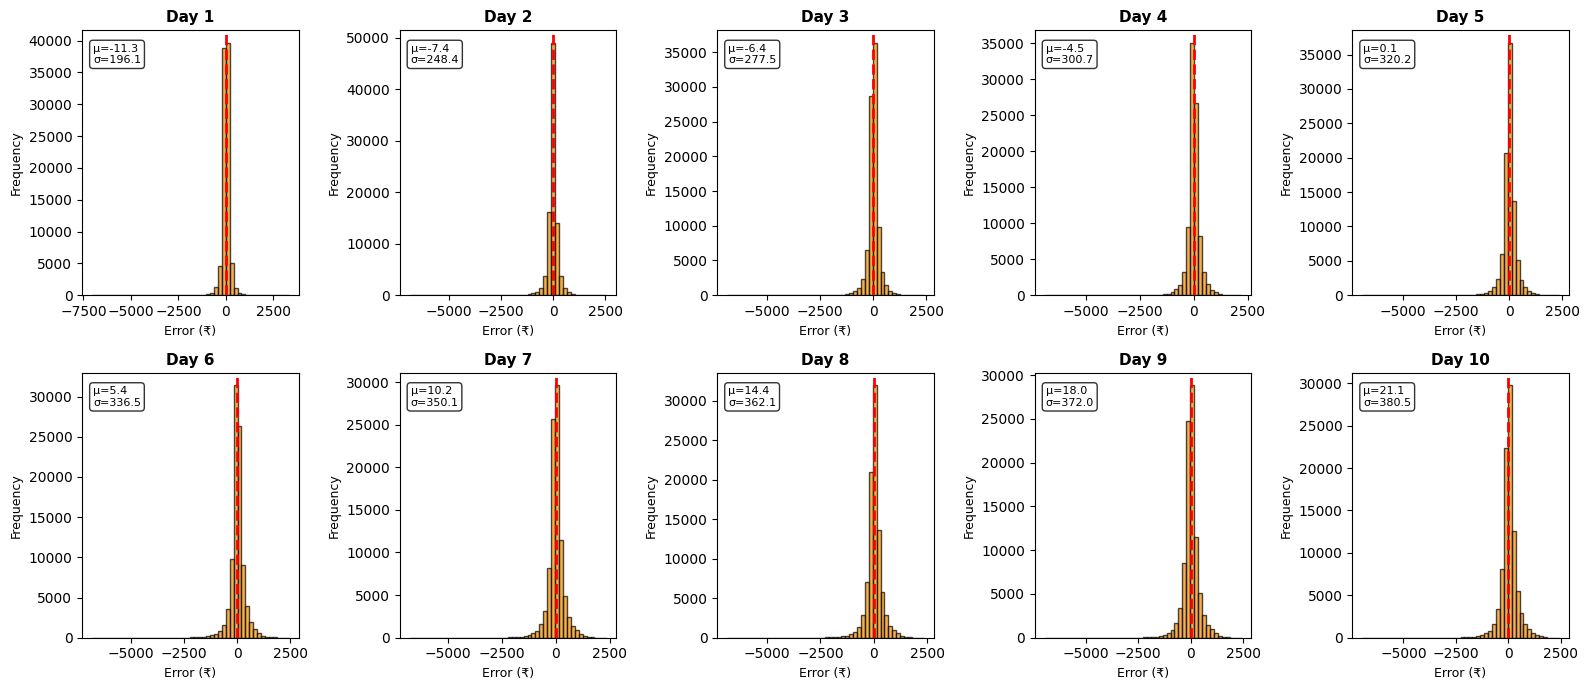

✓ Saved horizon degradation: horizon_degradation.png


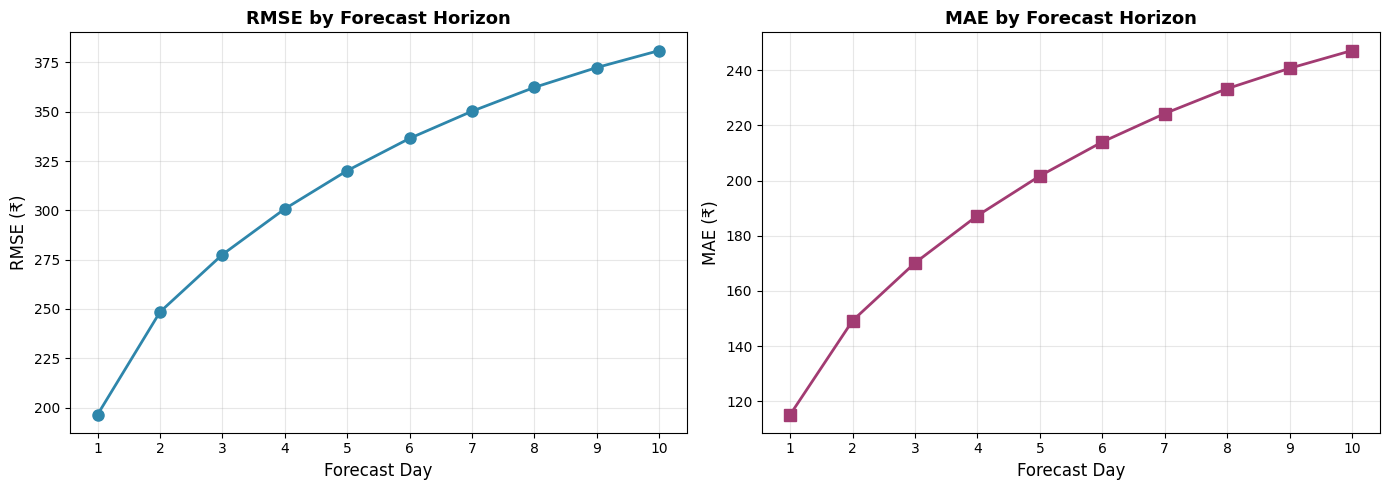

✓ Saved scatter plot: actual_vs_predicted.png


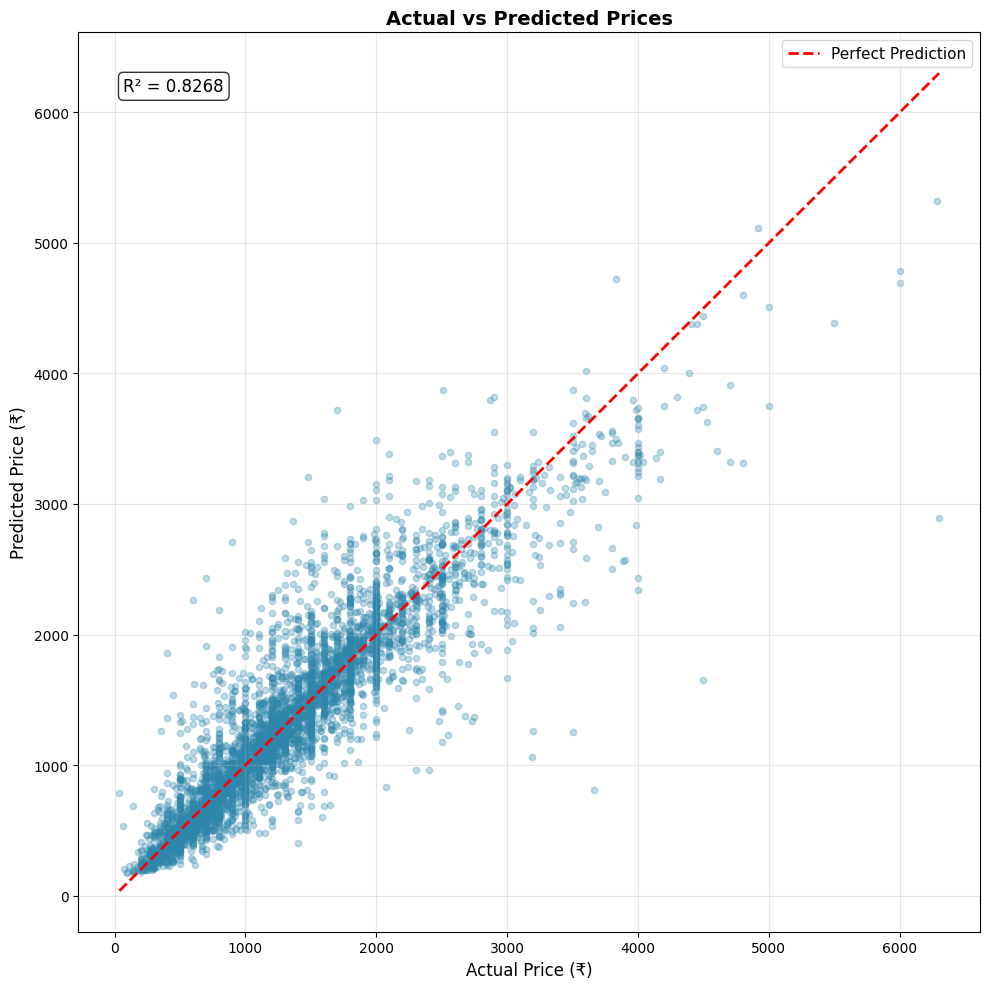


✅ Evaluation complete! All plots saved.


In [ ]:
# GAT-LSTM Evaluation for Kaggle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device, price_scaler):
    """Evaluate model on test set"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            X = batch['X'].to(device)
            y = batch['y'].to(device)
            mandi_idx = batch['mandi_idx'].to(device)
            crop_idx = batch['crop_idx'].to(device)
            edge_index = batch['edge_index'][0].to(device)
            edge_weights = batch['edge_weights'][0].to(device)
            
            predictions = model(X, edge_index, mandi_idx, crop_idx, edge_weights)
            
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(all_predictions, axis=0).squeeze(-1)
    targets = np.concatenate(all_targets, axis=0)
    
    # Denormalize
    predictions_denorm = price_scaler.inverse_transform(
        predictions.reshape(-1, 1)
    ).reshape(predictions.shape)
    
    targets_denorm = price_scaler.inverse_transform(
        targets.reshape(-1, 1)
    ).reshape(targets.shape)
    
    return predictions_denorm, targets_denorm

def calculate_metrics(predictions, targets):
    """Calculate comprehensive metrics"""
    # Overall metrics
    mse = mean_squared_error(targets.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets.flatten(), predictions.flatten())
    r2 = r2_score(targets.flatten(), predictions.flatten())
    mape = np.mean(np.abs((targets - predictions) / (targets + 1e-8))) * 100
    
    # Per-horizon metrics
    horizon_metrics = []
    for h in range(predictions.shape[1]):
        h_mse = mean_squared_error(targets[:, h], predictions[:, h])
        h_mae = mean_absolute_error(targets[:, h], predictions[:, h])
        h_rmse = np.sqrt(h_mse)
        horizon_metrics.append({
            'day': h + 1,
            'rmse': h_rmse,
            'mae': h_mae
        })
    
    return {
        'overall': {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape},
        'per_horizon': horizon_metrics
    }

def print_metrics(metrics):
    """Print evaluation metrics"""
    print("\n" + "="*60)
    print("EVALUATION METRICS")
    print("="*60)
    
    print("\n📊 Overall Performance:")
    for metric, value in metrics['overall'].items():
        print(f"  {metric}: {value:.4f}")
    
    print("\n📈 Per-Day Performance:")
    print(f"{'Day':<6} {'RMSE':<12} {'MAE':<12}")
    print("-"*35)
    for h_metrics in metrics['per_horizon']:
        print(f"{h_metrics['day']:<6} ₹{h_metrics['rmse']:<11.2f} ₹{h_metrics['mae']:<11.2f}")
    
    print("="*60)

def plot_predictions(predictions, targets, num_samples=6):
    """Plot sample predictions vs actual"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(predictions))
        
        axes[i].plot(range(1, 11), targets[idx], 'o-', 
                    label='Actual', linewidth=2, markersize=6, color='#2E86AB')
        axes[i].plot(range(1, 11), predictions[idx], 's-', 
                    label='Predicted', linewidth=2, markersize=6, color='#A23B72')
        axes[i].set_xlabel('Forecast Day', fontsize=10)
        axes[i].set_ylabel('Price (₹)', fontsize=10)
        axes[i].set_title(f'Sample {i+1}', fontsize=11, fontweight='bold')
        axes[i].legend(loc='best', fontsize=9)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved predictions plot: predictions.png")
    plt.show()

def plot_error_distribution(predictions, targets):
    """Plot error distribution by forecast horizon"""
    errors = predictions - targets
    
    fig, axes = plt.subplots(2, 5, figsize=(16, 7))
    axes = axes.flatten()
    
    for h in range(10):
        axes[h].hist(errors[:, h], bins=50, alpha=0.7, 
                    edgecolor='black', color='#F18F01')
        axes[h].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[h].set_title(f'Day {h+1}', fontsize=11, fontweight='bold')
        axes[h].set_xlabel('Error (₹)', fontsize=9)
        axes[h].set_ylabel('Frequency', fontsize=9)
        
        # Add mean and std
        mean_err = errors[:, h].mean()
        std_err = errors[:, h].std()
        axes[h].text(0.05, 0.95, f'μ={mean_err:.1f}\nσ={std_err:.1f}',
                    transform=axes[h].transAxes, fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=150, bbox_inches='tight')
    print("✓ Saved error distribution: error_distribution.png")
    plt.show()

def plot_horizon_degradation(metrics):
    """Plot how accuracy degrades over forecast horizon"""
    days = [m['day'] for m in metrics['per_horizon']]
    rmse = [m['rmse'] for m in metrics['per_horizon']]
    mae = [m['mae'] for m in metrics['per_horizon']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # RMSE
    ax1.plot(days, rmse, 'o-', linewidth=2, markersize=8, color='#2E86AB')
    ax1.set_xlabel('Forecast Day', fontsize=12)
    ax1.set_ylabel('RMSE (₹)', fontsize=12)
    ax1.set_title('RMSE by Forecast Horizon', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(days)
    
    # MAE
    ax2.plot(days, mae, 's-', linewidth=2, markersize=8, color='#A23B72')
    ax2.set_xlabel('Forecast Day', fontsize=12)
    ax2.set_ylabel('MAE (₹)', fontsize=12)
    ax2.set_title('MAE by Forecast Horizon', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(days)
    
    plt.tight_layout()
    plt.savefig('horizon_degradation.png', dpi=150, bbox_inches='tight')
    print("✓ Saved horizon degradation: horizon_degradation.png")
    plt.show()

def plot_actual_vs_predicted_scatter(predictions, targets):
    """Scatter plot of actual vs predicted prices"""
    plt.figure(figsize=(10, 10))
    
    # Sample points for clarity (too many points = cluttered)
    sample_size = min(5000, len(predictions.flatten()))
    indices = np.random.choice(len(predictions.flatten()), sample_size, replace=False)
    
    pred_flat = predictions.flatten()[indices]
    target_flat = targets.flatten()[indices]
    
    plt.scatter(target_flat, pred_flat, alpha=0.3, s=20, color='#2E86AB')
    
    # Perfect prediction line
    min_val = min(target_flat.min(), pred_flat.min())
    max_val = max(target_flat.max(), pred_flat.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Price (₹)', fontsize=12)
    plt.ylabel('Predicted Price (₹)', fontsize=12)
    plt.title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add R² annotation
    r2 = r2_score(target_flat, pred_flat)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png', dpi=150, bbox_inches='tight')
    print("✓ Saved scatter plot: actual_vs_predicted.png")
    plt.show()

# Create test dataset and loader
test_dataset = SpatiotemporalDataset(test_data, graph_data['edge_index'], graph_data['edge_weights'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate
predictions, targets = evaluate_model(model, test_loader, device, metadata['price_scaler'])

# Calculate metrics
metrics = calculate_metrics(predictions, targets)
print_metrics(metrics)

print("\n📊 Generating visualizations...\n")

# 1. Sample predictions
plot_predictions(predictions, targets, num_samples=6)

# 2. Error distribution
plot_error_distribution(predictions, targets)

# 3. Horizon degradation
plot_horizon_degradation(metrics)

# 4. Actual vs Predicted scatter
plot_actual_vs_predicted_scatter(predictions, targets)

print("\n✅ Evaluation complete! All plots saved.")
